# Rayleigh Plesset Equation

The Rayleigh Plesset Equation (without viscous dissipation) is given by Eq. (1):
\begin{equation}
R \ddot{R} +\frac{3}{2} \dot{R}^2=\frac{p_v-p_\infty(t)}{\rho}+\frac{p_{g0}}{\rho}\left(\frac{R_0}{R}\right)^{3\kappa}-\frac{2\sigma}{\rho R}\tag{1}
\end{equation}
The driving of the bubble occurs through the pressure $p_\infty(t)$ term. This could be for example through a harmonic driving $p_\infty(t)=p_0 + p_a \sin (\omega t)$ where $\omega$ is the angular frequency, $p_0$ the static pressure, and $p_a$ the amplitude of the driving.

We want to solve this equation for small and large oscillations, i.e. for small and large pressures $p_a$. To do so we first define the constants for an air bubble in water at room temperature undergoing isothermal compression.

In [1]:
%matplotlib inline 
import numpy as np #work with arrays
from scipy import integrate
#from scipy.integrate import odeint
from matplotlib.pylab import *
from IPython import display
from ipywidgets import widgets

pv=2.3388e3     #[Pa] vapour pressure of water
sigma=0.072     #[N/m] coefficient of surface tension between air and water
rho=998.        #[kg/m^3] density of water
kappa=1.       #polytropic exponent of the gas
p0=1e5          #[Pa] static pressure
nu=1e-6         #[m^2/s]

The gas pressure at equilibrium is given by the equilibrium condition

\begin{equation}
p_v+p_{g0}=p_\infty+\frac{2\sigma}{R}\tag{2}
\end{equation}

We can solve this nonlinear ODE with the built in solver in python. Therefore, we have to rephrase the 2nd Order ODE into two first order ODEs by variable substitution:

\begin{eqnarray}
y_0&=&R\tag{3a}\\
y_1&=&\tag{3b}\dot{R}
\end{eqnarray}

\begin{equation}
\dot{R}=\frac{dy_0}{dt}=y_1 \tag{4}
\end{equation}
and using the Rayleigh Equation we obtain:
\begin{equation}
\ddot{R}=\frac{dy_1}{dt}=\frac{1}{y_0}\left[
\frac{p_v-p_\infty(t)}{\rho}+\frac{p_g0}{\rho}\left(\frac{R_0}{y_0}\right)^{3\kappa}-\frac{2\sigma}{\rho y_0}-\frac{3}{2}(y_1)^2
\right]\tag{5}
\end{equation}

We use a slightly modified version of the equation by introducing additionally some dissipation from viscosity of the liquid. This term is added on thr R.H.S of Eq. (5) which is $-4\mu\dot{R}{R}^{-1}$.

These two first order ODEs are defined in the function `rp(t,y)`

In [8]:
def rp(t,y):
    global f, pa, R0, ncycles
    pinfty=p0-pa*np.sin(f*2.*np.pi*t)*(1./f*ncycles/2.>t)
    pg0=p0+2.*sigma/R0-pv
    dydt0=y[1]
    dydt1=(pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
           -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
           -4.*nu*y[1]/y[0]/y[0]
    return [dydt0,dydt1]

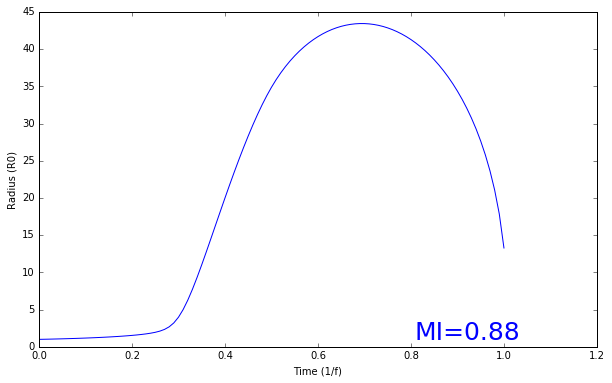

In [10]:
def plotall(newvalue):
    global f
    global pa
    global R0
    global ncycles
    
    f=w_frequency.value*1.e6
    pa=w_pressure.value*1.e5
    R0=w_R0.value*1.e-6
    ncycles=float(w_ncycles.value)
    
    plt.figure(1, figsize=(10, 6), dpi=200)
    plt.clf
    
    t_sim=10./f
    delta_t = t_sim/1000.
    num_steps = int(t_sim/delta_t) + 3
    time = np.zeros((num_steps, 1))
    R = np.zeros((num_steps, 1))
    time[0] = 0.
    R[0] = R0

    ode15s = integrate.ode(rp)
    ode15s.set_initial_value([R[0],0.], 0.)

    k = 1
    while ode15s.successful() and ode15s.t < (t_sim):
        ode15s.integrate(ode15s.t+delta_t)
        time[k] = ode15s.t
        R[k] = ode15s.y[0]
        k += 1

    plt.plot(time[0:k-1]*f,R[0:k-1]/R0);
    plt.xlabel('Time (1/f)')
    plt.ylabel('Radius (R0)')
    plt.text(time[k-1]*f*.8,1.,\
             'MI={0:.2f}'.format(pa/1e6/np.sqrt(f/1e6)),\
             fontsize=25,color='b')

    display.clear_output(wait=True)

    #print ode15s.successful()

    
global f, pa, R0, ncycles
R0=3e-7
ncycles=1.
w_frequency=widgets.FloatSlider(min=.5,max=50,step=.25,\
                                       value=5,description='Frequency (MHz):')
w_pressure=widgets.FloatSlider(min=.1,max=30,step=.1,\
                                       value=.4,description='Acoustic amplitude (bar):')
w_R0=widgets.FloatSlider(min=.05,max=1,step=.05,\
                                       value=.3,description='Nucleus size (micrometer):')
w_ncycles=widgets.IntSlider(min=1,max=10,step=1,\
                                       value=1,description='Number of cyles')

w_frequency.observe(plotall, names='value') #auto update
w_pressure.observe(plotall, names='value') #auto update
w_R0.observe(plotall, names='value') #auto update
w_ncycles.observe(plotall, names='value')
display.display(w_frequency)
display.display(w_pressure)
display.display(w_R0)
display.display(w_ncycles)

plotall(1)